# Reducing ICESat-2 data files

* Select files of interest (segment and time)
* Select area of interest (subset lon/lat)
* Reduce selected files with variables of interest
* Filter data and separate tracks into asc/des
* Process/Read each file in parallel
* Plot some data to check everything went well

## How ICESat-2 files are organized 

ICESat-2 ground tracks are subsetted into granules (individual files)

Granules are then grouped into latitudinal bands (segments)

![Segments](segments.png "Latitudinal bands (Segments)")


File naming convention:

`ATL06_20181120202321_08130101_001_01.h5`

`ATL06_[yyyymmdd][hhmmss]_[RGTccss]_[vvv_rr].h5`

where

`ATL_06` => L3A Land Ice product    

`yyyymmdd` => Year, month, day of data acquisition    

`hhmmss` => Hour, minute, second of data acquisition   

`RGT` => Reference Ground Track    

`cc` => Cycle Number   

`ss` => Segment number (latitude band)   

`vvv_rr` => Version and revision numbers  

## Select files of interest

We will use the **file name** info for this (no need to open the files).  

Alternatively, we could retrieve this info from the **Metadata**.

To select files withint a time interval and segment, all we need is:

`yyyymmdd, hhmmss, ss`

Let's firt get a list with all file names

In [100]:
import getpass


def list_files_local(path):
    """ Get file list form local folder. """
    from glob import glob
    return glob(path)


def list_files_s3(path):
    """ Get file list from Amazon S3. """
    import s3fs
    return s3fs.S3FileSystem().glob(path)


def list_files_ssh(path, host, user, pwd):
    """ Get file list from remote folder usgin SSH. """
    import paramiko

    # Create an SSH client instance.
    ssh = paramiko.SSHClient()

    # Create a 'host_keys' object
    # and load the local known hosts  
    host_keys = ssh.load_system_host_keys()

    # Connect to our client w/remote machine credentials
    ssh.connect(host, username=user, password=pwd)

    # Execute command on remote system,
    # and get input, output and error variables
    stdin, stdout, stderr = ssh.exec_command('ls '+path)

    # Iterate over stdout
    files = [line.strip('\n') for line in stdout]

    # Close the connection to client
    ssh.close()
    return files
    

if 0:
    path = 'data/*.h5'
    files = list_files_local(path)
    
elif 0:
    path = 'pangeo-data-upload-oregon/icesat2/atl06/*.h5'
    #path = 's3://pangeo-data-upload-oregon/icesat2/data-access-outputs/*.h5'
    files = list_files_s3(path)
       
else:    
    path = '/u/devon-r2/shared_data/icesat2/atl06/rel209/raw/*.h5'
    host = 'devon.jpl.nasa.gov'
    user = 'paolofer'
    pwd = getpass.getpass('Password:')
    files = list_files_ssh(path, host, user, pwd)
    

for f in files[:5]: print(f)
print('Total number of files:', len(files))

Password:········
/u/devon-r2/shared_data/icesat2/atl06/rel209/raw/ATL06_20181013235645_02340114_209_01.h5
/u/devon-r2/shared_data/icesat2/atl06/rel209/raw/ATL06_20181014000347_02350101_209_01.h5
/u/devon-r2/shared_data/icesat2/atl06/rel209/raw/ATL06_20181014001049_02350102_209_01.h5
/u/devon-r2/shared_data/icesat2/atl06/rel209/raw/ATL06_20181014001920_02350103_209_01.h5
/u/devon-r2/shared_data/icesat2/atl06/rel209/raw/ATL06_20181014002445_02350104_209_01.h5
Total number of files: 26642


Filter file names by segment and time interval

In [5]:
import os
import datetime as dt

# File name format: ATL06_[yyyymmdd][hhmmss]_[RGTccss]_[vvv_rr].h5

#NOTE: Need to simplify this function
def time_from_fname(fname):
    """ IS2 fname -> datatime object. """
    t = fname.split('_')[1]
    y, m , d, h, mn, s = t[:4], t[4:6], t[6:8], t[8:10], t[10:12], t[12:14]
    time = dt.datetime(int(y), int(m), int(d), int(h), int(mn), int(s))
    return time


def segment_from_fname(fname):
    """ IS2 fname -> segment number. """
    s = fname.split('_')[2]
    return int(s[-2:])


def select_files(files, segments=[10,11,12], t1=(2019,1,1), t2=(2019,2,1)):
    t1 = dt.datetime(*t1)
    t2 = dt.datetime(*t2)
    files_out = []
    for f in files:
        fname = os.path.basename(f)
        time = time_from_fname(fname)
        segment = segment_from_fname(fname)
        if t1 <= time <= t2 and segment in segments:
            files_out.append(f)
    return files_out

In [6]:
# Update file list
files = select_files(files, segments=[10,11,12], t1=(2019,1,1), t2=(2019,2,1))

for f in files[:5]: print(f)
print('Number of files:', len(files))

/u/devon-r2/shared_data/icesat2/atl06/rel209/raw/ATL06_20190101001723_00540210_209_01.h5
/u/devon-r2/shared_data/icesat2/atl06/rel209/raw/ATL06_20190101002504_00540211_209_01.h5
/u/devon-r2/shared_data/icesat2/atl06/rel209/raw/ATL06_20190101003047_00540212_209_01.h5
/u/devon-r2/shared_data/icesat2/atl06/rel209/raw/ATL06_20190101015140_00550210_209_01.h5
/u/devon-r2/shared_data/icesat2/atl06/rel209/raw/ATL06_20190101015921_00550211_209_01.h5
Number of files: 1402


## Download files of interest

 **Tip!** You can download the entire folder from S3 using the `aws client`.

Install and setup `aws client`:  
https://www.viget.com/articles/set-up-aws-cli-and-download-your-s3-files-from-the-command-line/  

List and download folder content from the terminal:  

In [7]:
!aws s3 ls s3://pangeo-data-upload-oregon/icesat2/atl06/  
#!aws s3 sync s3://pangeo-data-upload-oregon/icesat2/atl06/ data/


Could not connect to the endpoint URL: "https://pangeo-data-upload-oregon.s3.Oregon.amazonaws.com/?list-type=2&prefix=icesat2%2Fatl06%2F&delimiter=%2F&encoding-type=url"


Download selected files with Python

In [14]:
import getpass

def get_files_s3(files, opath):
    """ Download files from Amazon S3. """
    import os
    import s3fs
    os.chdir(opath)  # change current dir
    for f in files: 
        print(f)
        s3fs.S3FileSystem().get(f)

        
def get_files_ssh(files, opath, host, user, pwd):      
    import os
    files = ' '.join(files)
    os.system("rsync -Pav '%s@%s:%s' %s" % (user, host, files, opath))
    print('files saved ->', opath)
    

if 0:
    get_files_s3(files, 'data/')
    
else:
    opath = 'data/'
    host = 'devon.jpl.nasa.gov'
    user = 'paolofer'
    pwd = getpass.getpass('Password:')
    get_files_ssh(files[:3], opath, host, user, pwd)

Password:········
files saved -> data/


## Reducing ICESat-2 files

***
**NOTE:** 

+ **This is neither the only nor the best way to handled ICESat-2 data files.**

+ **This is *one* way that works well for large-scale processing (e.g. full continent) on parallel machines (e.g. HPC clusters).**

+ **The idea is to (a) simplify the I/O of a complex workflow and (b) take advantage of embrrasingly parallelization.**
***

Let's check the ICESat-2 file structure

In [15]:
!ls data/*.h5

data/ATL06_20190101001723_00540210_209_01.h5
data/ATL06_20190101002504_00540211_209_01.h5
data/ATL06_20190101003047_00540212_209_01.h5


In [17]:
!h5ls -r data/ATL06_20190101001723_00540210_209_01.h5

/                        Group
/METADATA                Group
/METADATA/AcquisitionInformation Group
/METADATA/AcquisitionInformation/lidar Group
/METADATA/AcquisitionInformation/lidarDocument Group
/METADATA/AcquisitionInformation/platform Group
/METADATA/AcquisitionInformation/platformDocument Group
/METADATA/DataQuality    Group
/METADATA/DataQuality/CompletenessOmission Group
/METADATA/DataQuality/DomainConsistency Group
/METADATA/DatasetIdentification Group
/METADATA/Extent         Group
/METADATA/Lineage        Group
/METADATA/Lineage/ANC06-01 Group
/METADATA/Lineage/ANC06-02 Group
/METADATA/Lineage/ANC06-03 Group
/METADATA/Lineage/ANC17  Group
/METADATA/Lineage/ANC19  Group
/METADATA/Lineage/ANC25-06 Group
/METADATA/Lineage/ANC26-06 Group
/METADATA/Lineage/ANC28  Group
/METADATA/Lineage/ANC36-06 Group
/METADATA/Lineage/ANC38-06 Group
/METADATA/Lineage/ATL03  Group
/METADATA/Lineage/ATL09  Group
/METADATA/Lineage/Control Group
/METADATA/ProcessStep    Group
/METADATA/ProcessStep/

/gt1r/land_ice_segments/geophysical/solar_elevation Dataset {36131/Inf}
/gt1r/land_ice_segments/geophysical/tide_earth Dataset {36131/Inf}
/gt1r/land_ice_segments/geophysical/tide_load Dataset {36131/Inf}
/gt1r/land_ice_segments/geophysical/tide_ocean Dataset {36131/Inf}
/gt1r/land_ice_segments/geophysical/tide_pole Dataset {36131/Inf}
/gt1r/land_ice_segments/ground_track Group
/gt1r/land_ice_segments/ground_track/ref_azimuth Dataset {36131/Inf}
/gt1r/land_ice_segments/ground_track/ref_coelv Dataset {36131/Inf}
/gt1r/land_ice_segments/ground_track/seg_azimuth Dataset {36131/Inf}
/gt1r/land_ice_segments/ground_track/sigma_geo_at Dataset {36131/Inf}
/gt1r/land_ice_segments/ground_track/sigma_geo_xt Dataset {36131/Inf}
/gt1r/land_ice_segments/ground_track/x_atc Dataset {36131/Inf}
/gt1r/land_ice_segments/ground_track/y_atc Dataset {36131/Inf}
/gt1r/land_ice_segments/h_li Dataset {36131/Inf}
/gt1r/land_ice_segments/h_li_sigma Dataset {36131/Inf}

/gt1r/land_ice_segments/longitude Dataset {

/gt3r/land_ice_segments/geophysical/cloud_flg_asr Dataset {36330/Inf}
/gt3r/land_ice_segments/geophysical/cloud_flg_atm Dataset {36330/Inf}
/gt3r/land_ice_segments/geophysical/dac Dataset {36330/Inf}
/gt3r/land_ice_segments/geophysical/e_bckgrd Dataset {36330/Inf}
/gt3r/land_ice_segments/geophysical/msw_flag Dataset {36330/Inf}
/gt3r/land_ice_segments/geophysical/neutat_delay_total Dataset {36330/Inf}
/gt3r/land_ice_segments/geophysical/r_eff Dataset {36330/Inf}
/gt3r/land_ice_segments/geophysical/solar_azimuth Dataset {36330/Inf}
/gt3r/land_ice_segments/geophysical/solar_elevation Dataset {36330/Inf}
/gt3r/land_ice_segments/geophysical/tide_earth Dataset {36330/Inf}
/gt3r/land_ice_segments/geophysical/tide_load Dataset {36330/Inf}
/gt3r/land_ice_segments/geophysical/tide_ocean Dataset {36330/Inf}
/gt3r/land_ice_segments/geophysical/tide_pole Dataset {36330/Inf}
/gt3r/land_ice_segments/ground_track Group
/gt3r/land_ice_segments/ground_track/ref_azimuth Dataset {36330/Inf}
/gt3r/land_ic

Let's code a simple reader that:

- Select variables of interest (x, y, t, h...)  
- Filter data points based on quality flag and bbox   
- Separate into beams and ascending/descending tracks  
- Save data to a simpler HDF5 structure (redundancy/efficiency)

Some utility functions

In [60]:
import pyproj
from astropy.time import Time

def gps2dyr(time):
    """ Converte GPS time to decimal years. """
    return Time(time, format='gps').decimalyear


def track_type(time, lat, tmax=1):
    """
    Separate tracks into ascending and descending.
    
    Defines tracks as segments with time breaks > tmax,
    and tests whether lat increases or decreases w/time.
    """
    tracks = np.zeros(lat.shape)  # generate track segment
    tracks[0:np.argmax(np.abs(lat))] = 1  # set values for segment
    i_asc = np.zeros(tracks.shape, dtype=bool)  # output index array

    # Loop trough individual secments
    for track in np.unique(tracks):
    
        i_track, = np.where(track == tracks)  # get all pts from seg
    
        if len(i_track) < 2: continue
    
        # Test if lat increases (asc) or decreases (des) w/time
        i_min = time[i_track].argmin()
        i_max = time[i_track].argmax()
        lat_diff = lat[i_track][i_max] - lat[i_track][i_min]
    
        # Determine track type
        if lat_diff > 0:  i_asc[i_track] = True
    
    return i_asc, np.invert(i_asc)  # index vectors


def transform_coord(proj1, proj2, x, y):
    """
    Transform coordinates from proj1 to proj2 (EPSG num).

    Example EPSG projs:
        Geodetic (lon/lat): 4326
        Polar Stereo AnIS (x/y): 3031
        Polar Stereo GrIS (x/y): 3413
    """
    # Set full EPSG projection strings
    proj1 = pyproj.Proj("+init=EPSG:"+str(proj1))
    proj2 = pyproj.Proj("+init=EPSG:"+str(proj2))
    return pyproj.transform(proj1, proj2, x, y)  # convert


The simple reader

In [76]:
import h5py
import numpy as np

def read_atl06(fname, bbox=None):
    """ 
    Read 1 ATL06 file and output 6 reduced files. 
    
    Extract variables of interest and separate the ATL06 file 
    into each beam (ground track) and ascending/descending orbits.
    """

    # Each beam is a group
    group = ['/gt1l', '/gt1r', '/gt2l', '/gt2r', '/gt3l', '/gt3r']

    # Loop trough beams
    for k,g in enumerate(group):
    
        #-----------------------------------#
        # 1) Read in data for a single beam #
        #-----------------------------------#
    
        # Load variables into memory (more can be added!)
        with h5py.File(fname, 'r') as fi:
            lat = fi[g+'/land_ice_segments/latitude'][:]
            lon = fi[g+'/land_ice_segments/longitude'][:]
            h_li = fi[g+'/land_ice_segments/h_li'][:]
            s_li = fi[g+'/land_ice_segments/h_li_sigma'][:]
            t_dt = fi[g+'/land_ice_segments/delta_time'][:]
            q_flag = fi[g+'/land_ice_segments/atl06_quality_summary'][:]
            s_fg = fi[g+'/land_ice_segments/fit_statistics/signal_selection_source'][:]
            snr = fi[g+'/land_ice_segments/fit_statistics/snr_significance'][:]
            h_rb = fi[g+'/land_ice_segments/fit_statistics/h_robust_sprd'][:]
            dac = fi[g+'/land_ice_segments/geophysical/dac'][:]
            f_sn = fi[g+'/land_ice_segments/geophysical/bsnow_conf'][:]
            dh_fit_dx = fi[g+'/land_ice_segments/fit_statistics/dh_fit_dx'][:]
            tide_earth = fi[g+'/land_ice_segments/geophysical/tide_earth'][:]
            tide_load = fi[g+'/land_ice_segments/geophysical/tide_load'][:]
            tide_ocean = fi[g+'/land_ice_segments/geophysical/tide_ocean'][:]
            tide_pole = fi[g+'/land_ice_segments/geophysical/tide_pole'][:]
            t_ref = fi['/ancillary_data/atlas_sdp_gps_epoch'][:]
            rgt = fi['/orbit_info/rgt'][:] * np.ones(len(lat))
            orb = np.full_like(h_li, k)

        #---------------------------------------------#
        # 2) Filter data according region and quality #
        #---------------------------------------------#
        
        # Select a region of interest
        if bbox:
            lonmin, lonmax, latmin, latmax = bbox
            bbox_mask = (lon >= lonmin) & (lon <= lonmax) & \
                        (lat >= latmin) & (lat <= latmax)
        else:
            bbox_mask = np.ones_like(lat, dtype=bool)  # get all
            
        # Only keep good data, and data inside bbox
        mask = (q_flag == 0) & (np.abs(h_li) < 10e3) & (bbox_mask == 1)
        
        # Update variables
        lat, lon, h_li, s_li, t_dt, h_rb, s_fg, snr, q_flag, f_sn, \
            tide_earth, tide_load, tide_ocean, tide_pole, dac, rgt, orb = \
                lat[mask], lon[mask], h_li[mask], s_li[mask], t_dt[mask], \
                h_rb[mask], s_fg[mask], snr[mask], q_flag[mask], f_sn[mask], \
                tide_earth[mask], tide_load[mask], tide_ocean[mask], \
                tide_pole[mask], dac[mask], rgt[mask], orb[mask]

        # Test for no data
        if len(h_li) == 0: continue

        #-------------------------------------#
        # 3) Convert time and separate tracks #
        #-------------------------------------#
        
        # Time in GPS seconds (secs sinde 1980...)
        t_gps = t_ref + t_dt

        # Time in decimal years
        t_year = gps2dyr(t_gps)

        # Determine orbit type
        i_asc, i_des = track_type(t_year, lat)
        
        #-----------------------#
        # 4) Save selected data #
        #-----------------------#
        
        # Define output file name
        ofile = fname.replace('.h5', '_'+g[1:]+'.h5')
                
        # Save variables
        with h5py.File(ofile, 'w') as f:
            f['orbit'] = orb
            f['lon'] = lon
            f['lat'] = lat
            f['h_elv'] = h_li
            f['t_year'] = t_year
            f['t_sec'] = t_gps
            f['s_elv'] = s_li
            f['h_rb'] = h_rb
            f['s_fg'] = s_fg
            f['snr'] = snr
            f['q_flg'] = q_flag
            f['f_sn'] = f_sn
            f['tide_load'] = tide_load
            f['tide_ocean'] = tide_ocean
            f['tide_pole'] = tide_pole
            f['tide_earth'] = tide_earth
            f['dac'] = dac
            f['rgt'] = rgt
            f['trk_type'] = i_asc

            print('out ->', ofile)
                

## Simple parallelization

* If your problem is embarrasingly parallel, it's easy to parallelize
* We can use the very simple and lightweight `joblib` library
* There is no need to modify your code!

Read more: [https://joblib.readthedocs.io](https://joblib.readthedocs.io)

In [77]:
njobs = 3

files = list_files_local('data/*_01.h5')

#NOTE: Using Kamb bounding box for now
bbox = None #[-1124782, 81623, -919821, -96334]

if njobs == 1:
    print('running in serial ...')
    [read_atl06(f, bbox) for f in files]

else:
    print('running in parallel (%d jobs) ...' % njobs)
    from joblib import Parallel, delayed
    Parallel(n_jobs=njobs, verbose=5)(delayed(read_atl06)(f, bbox) for f in files)


running in parallel (3 jobs) ...


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.6s finished


Let's check our created files

In [78]:
!ls data/*.h5

data/ATL06_20190101001723_00540210_209_01.h5
data/ATL06_20190101001723_00540210_209_01_gt1l.h5
data/ATL06_20190101001723_00540210_209_01_gt1r.h5
data/ATL06_20190101001723_00540210_209_01_gt2l.h5
data/ATL06_20190101001723_00540210_209_01_gt2r.h5
data/ATL06_20190101001723_00540210_209_01_gt3l.h5
data/ATL06_20190101001723_00540210_209_01_gt3r.h5
data/ATL06_20190101002504_00540211_209_01.h5
data/ATL06_20190101002504_00540211_209_01_gt1l.h5
data/ATL06_20190101002504_00540211_209_01_gt1r.h5
data/ATL06_20190101002504_00540211_209_01_gt2l.h5
data/ATL06_20190101002504_00540211_209_01_gt2r.h5
data/ATL06_20190101002504_00540211_209_01_gt3l.h5
data/ATL06_20190101002504_00540211_209_01_gt3r.h5
data/ATL06_20190101003047_00540212_209_01.h5
data/ATL06_20190101003047_00540212_209_01_gt1l.h5
data/ATL06_20190101003047_00540212_209_01_gt1r.h5
data/ATL06_20190101003047_00540212_209_01_gt2l.h5
data/ATL06_20190101003047_00540212_209_01_gt2r.h5
data/ATL06_20190101003047_00540212_209_01_gt3l.h5
data/ATL06_2019

In [79]:
!h5ls -r data/ATL06_20190101001723_00540210_209_01_gt1l.h5

/                        Group
/dac                     Dataset {33573}
/f_sn                    Dataset {33573}
/h_elv                   Dataset {33573}
/h_rb                    Dataset {33573}
/lat                     Dataset {33573}
/lon                     Dataset {33573}
/orbit                   Dataset {33573}
/q_flg                   Dataset {33573}
/rgt                     Dataset {33573}
/s_elv                   Dataset {33573}
/s_fg                    Dataset {33573}
/snr                     Dataset {33573}
/t_sec                   Dataset {33573}
/t_year                  Dataset {33573}
/tide_earth              Dataset {33573}
/tide_load               Dataset {33573}
/tide_ocean              Dataset {33573}
/tide_pole               Dataset {33573}
/trk_type                Dataset {33573}


## Plot some data to check

* Plot track points within region to check
* Plot track/beam profiles to check

Reading data now becomes trivial!!!

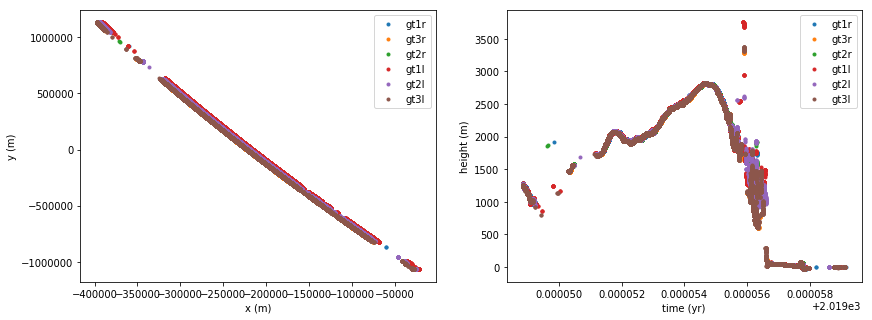

In [85]:
import matplotlib.pyplot as plt

def read_h5(fname, vnames=[]):
    """ Simple HDF5 reader. """
    with h5py.File(fname, 'r') as f:
        return [f[v][:] for v in vnames]

    
files = list_files_local('data/ATL06_20190101002504_00540211_209_01_gt*')

fig = plt.figure(figsize=(14,5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

for fname in files:

    lon, lat, t, h = read_h5(fname, ['lon', 'lat', 't_year', 'h_elv'])
    
    x, y = transform_coord(4326, 3031, lon, lat)
 
    ax1.plot(x, y, '.', label='%s' % fname[-7:-3])
    ax2.plot(t, h, '.', label='%s' % fname[-7:-3])
    
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
ax1.legend()
ax2.set_xlabel('time (yr)')
ax2.set_ylabel('height (m)')
ax2.legend()
plt.show()
    

## Single program from the command line

You can put all of the above (and more) into a single script and run it on the command line:

```
python readatl06.py -h

usage: readatl06.py [-h] [-o odir] [-f fmask] [-b w e s n] [-n njobs]
                    [-p epsg_num] [-i index] [-g gran [gran ...]]
                    ifile [ifile ...]

Program for reading ICESat ATL06 data.

positional arguments:
  ifile                 path for ifile(s) to read (.h5)

optional arguments:
  -h, --help            show this help message and exit
  -o odir               path to output folder
  -f fmask              name of raster file mask
  -b w e s n            bounding box for geographical region (deg)
  -n njobs              number of cores to use for parallel processing
  -p epsg_num           projection: EPSG number (AnIS=3031, GrIS=3413)
  -i index              provide mission index
  -g gran [gran ...]  only select specific granule(s)
```

Try reading the ICESat-2 files in parallel from the command line:

```
python readatl06.py data/*_01.h5 -n 3
```